In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import KFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostRegressor

from sklearn.neighbors import KNeighborsRegressor

from sklearn.svm import SVR

from sklearn.ensemble import StackingRegressor

## Reading Data

In [2]:
ins_data=pd.read_csv("DS_C12_S1_Regression_Insurance_Data_Project.csv")
ins_data

,age,gender,bmi,classif,children,smoker,region,charges
0,19,female,27.900,PREO,0,yes,southwest,16884.92400
1,18,male,33.770,OB1,1,no,southeast,1725.55230
2,28,male,33.000,OB1,3,no,southeast,4449.46200
3,0,male,22.705,N,0,no,northwest,21984.47061
4,32,male,28.880,PREO,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...,...
1333,50,male,30.970,OB1,3,no,northwest,10600.54830
1334,18,female,31.920,OB1,0,no,northeast,2205.98080
1335,18,female,36.850,OB2,0,no,southeast,1629.83350
1336,21,female,25.800,PREO,0,no,southwest,2007.94500


In [3]:
ins_data.shape

(1338, 8)

In [4]:
ins_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   gender    1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   classif   1330 non-null   object 
 4   children  1338 non-null   int64  
 5   smoker    1338 non-null   object 
 6   region    1338 non-null   object 
 7   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 83.8+ KB


### Data Preprocessing

In [5]:
ins_data.isnull().sum()

age         0
gender      0
bmi         0
classif     8
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
ins_data["classif"].mode()[0]

'OB1'

In [7]:
ins_data["classif"].fillna(ins_data["classif"].mode()[0],inplace=True)

In [8]:
ins_data.duplicated().sum()

1

In [9]:
ins_data.drop_duplicates(keep="last",inplace=True)
ins_data.reset_index(drop=True,inplace=True)

In [10]:
for i in ins_data:
    print(i,":",ins_data[i].nunique())

age : 51
gender : 2
bmi : 548
classif : 6
children : 6
smoker : 2
region : 4
charges : 1337


In [11]:
ins_data.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.148841,30.663452,1.095737,13279.121487
std,14.954106,6.100468,1.205571,12110.359656
min,-58.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,190.000000,53.130000,5.000000,63770.428010


### EDA

In [12]:
cat_cols=[]
cont_cols=[]
def cols(df):
    for i in df:
        if ins_data[i].nunique()<=20:
            cat_cols.append(i)
        else:
            cont_cols.append(i)

In [13]:
cols(ins_data)
print("categorical columns:",cat_cols)
print("continuous columns:",cont_cols)

categorical columns: ['gender', 'classif', 'children', 'smoker', 'region']
continuous columns: ['age', 'bmi', 'charges']


In [14]:
def bar_pie(*s):
    for col in s:
        fig,ax=plt.subplots(1,2,figsize=(10,3))
        sns.countplot(col,data=ins_data,ax=ax[0])
        ax[0].set_title(f"quantity of {col}")
        per=ins_data[col].value_counts(normalize=True)*100
        ax[1].pie(per.values,labels=per.index,autopct="%1.1f%%") 
        ax[1].set_title(f"percentage of {col}")
        plt.show()

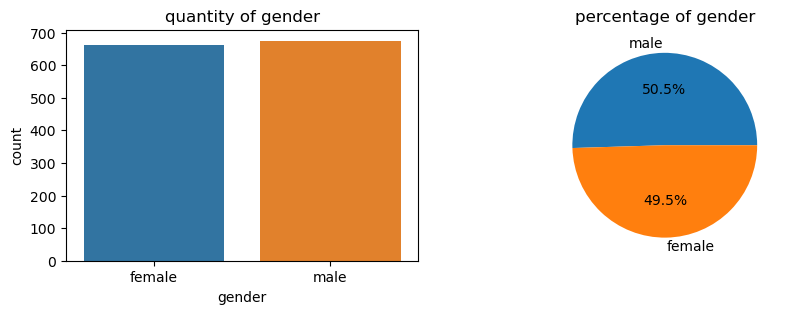

In [15]:
bar_pie("gender")

Gender wise data is well balanced

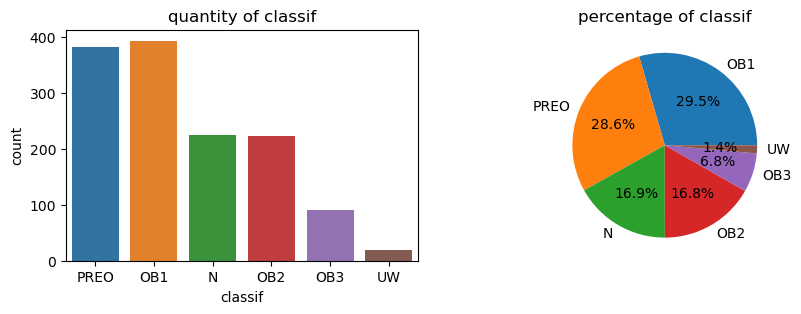

In [16]:
bar_pie("classif")

Most of the people are in Preo and OB1 category

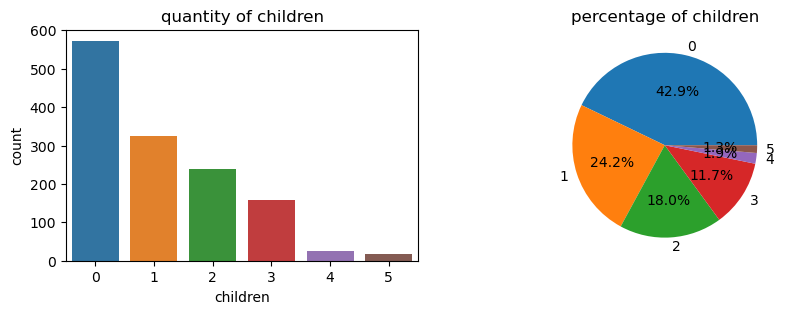

In [17]:
bar_pie("children")

 Most of the people do not have any child

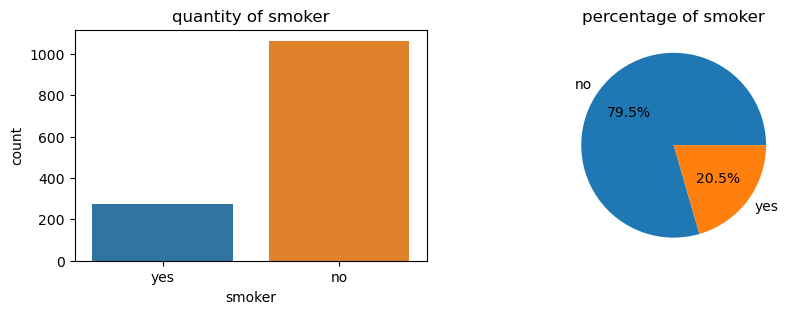

In [18]:
bar_pie("smoker")

80% of the people do not smoke

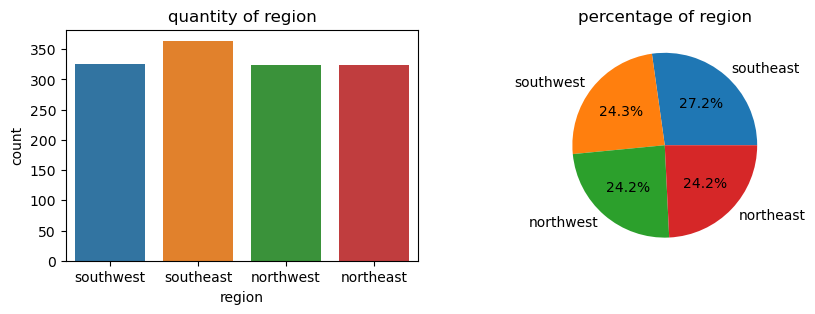

In [19]:
bar_pie("region")

Regions in the data is well balanced , people are from all the regions

In [20]:
def hist_box(*s):
    for col in s:
        values=ins_data[col].values
        fig,ax=plt.subplots(1,2,figsize=(15,4))
        sns.histplot(values,bins=20,ax=ax[0])
        ax[0].set_title(f"Distribution of {col} using histogram")
        ax[0].set_xlabel(f"{col}")
        ax[0].set_ylabel(f"frequency of {col}")


        sns.boxplot(y=ins_data[col],ax=ax[1])
        ax[1].set_title(f"Distribution using boxplot of {col}")
        plt.show()

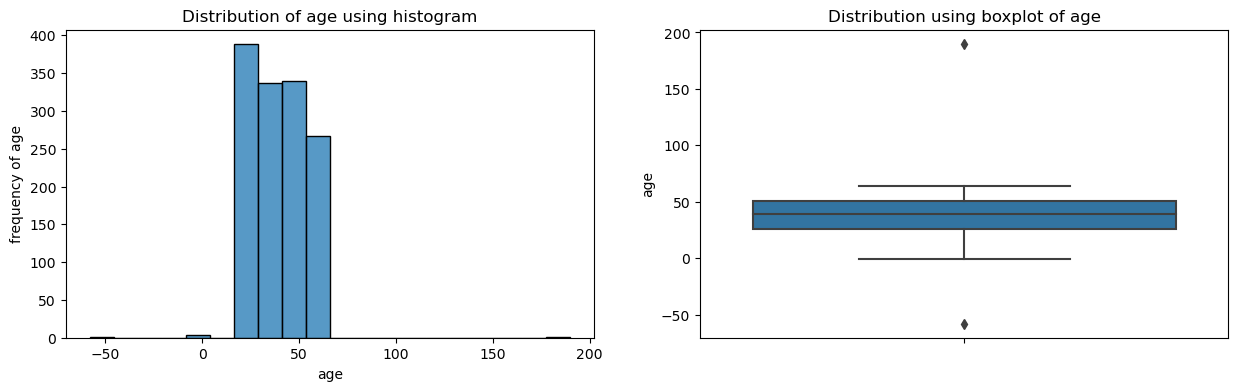

In [21]:
hist_box("age")

Here Age has negative number as well as maximum is 190 , which are not possible.
    So they are outliers we need to treat accordingly.


In [22]:
ins_data["age"][(ins_data["age"]<5)|(ins_data["age"]>100)]=round(ins_data["age"].mean(),0)

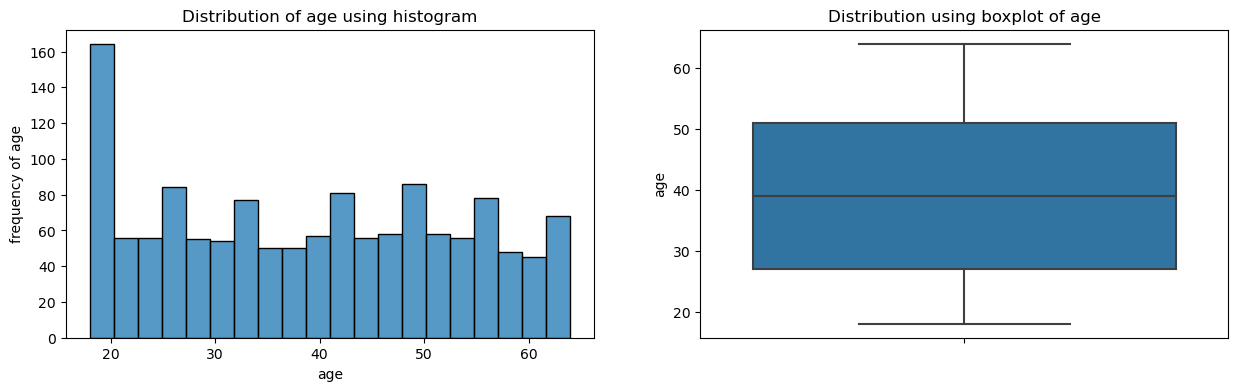

In [23]:
hist_box("age")

Most of the people's age in between 27 to 55

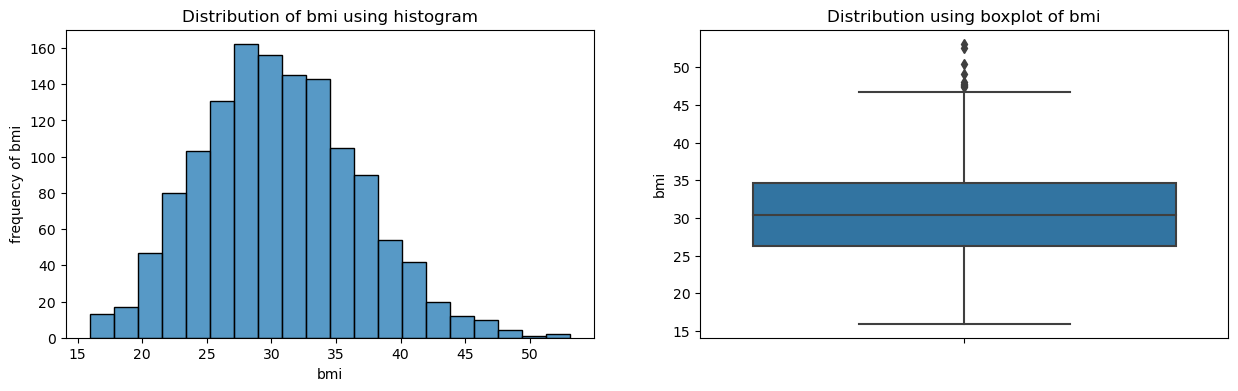

In [24]:
hist_box('bmi' )

in the data bmi concentration is around 25 to 35

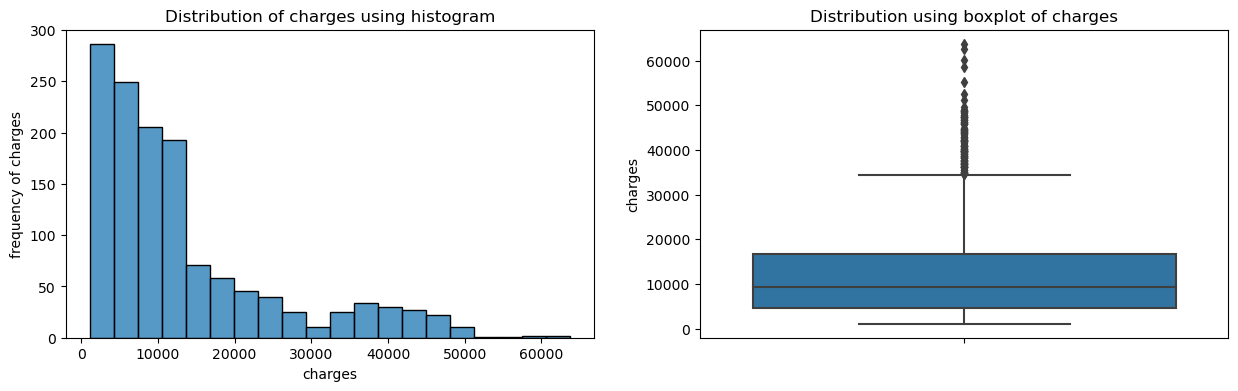

In [25]:
hist_box('charges')

Most of the charges comes under 20000.

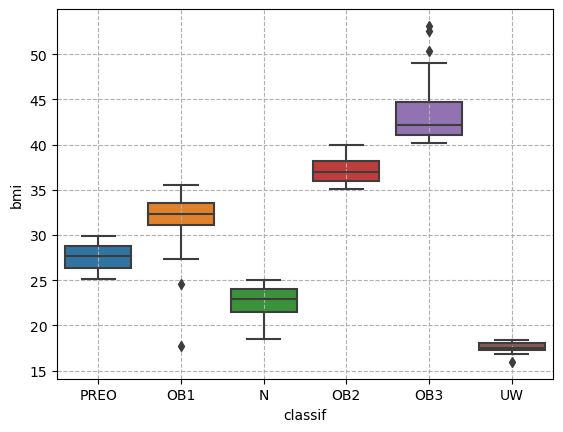

In [26]:
sns.boxplot(y="bmi",x="classif",data=ins_data)
plt.grid(axis='y', linestyle='--')
plt.grid(axis='x', linestyle='--')
plt.show()

In [27]:
cat_cols

['gender', 'classif', 'children', 'smoker', 'region']

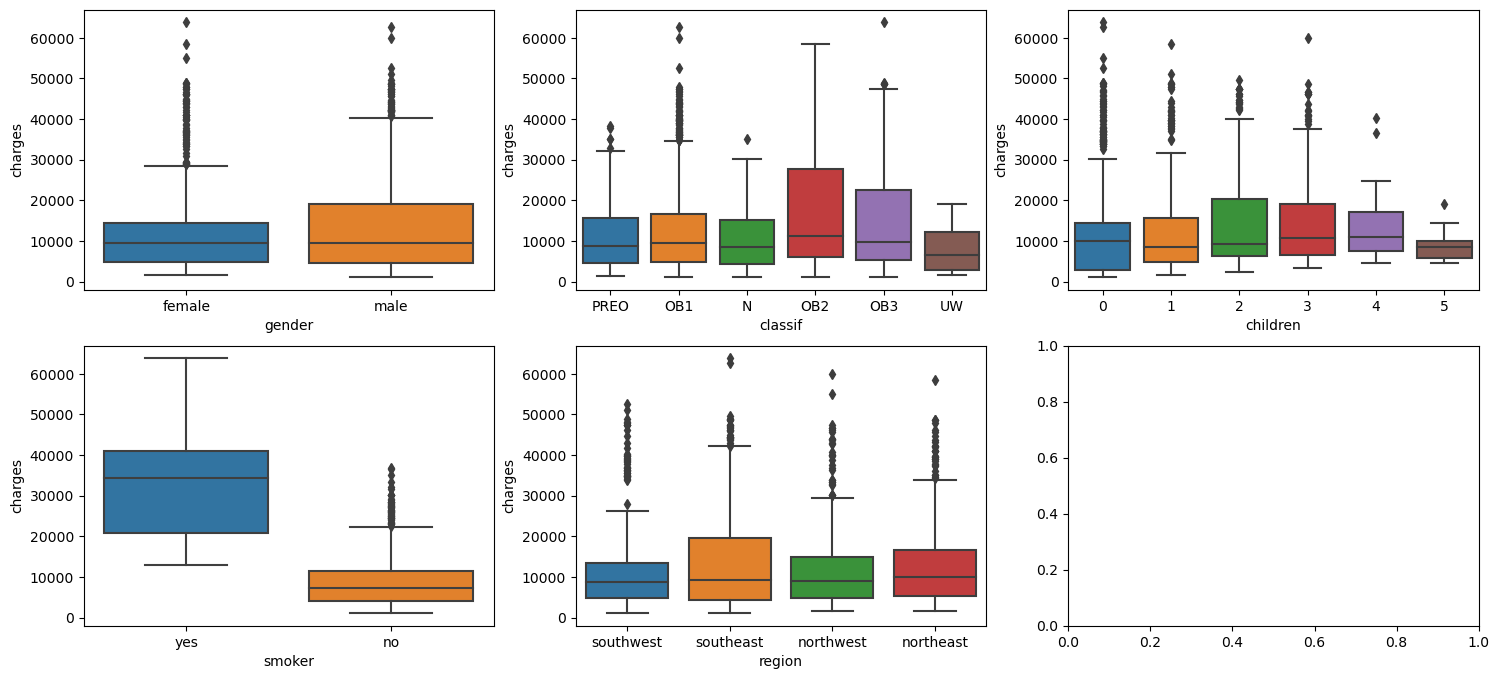

In [28]:
fig,axs=plt.subplots(2,3,figsize=(18,8))
axs=axs.ravel()
j=0
for i in cat_cols:
    sns.boxplot(y="charges",x=i,data=ins_data,ax=axs[j])
    j+=1
plt.show()

### Feature Selection

In [29]:
for col in ins_data.select_dtypes("object"):
    ins_data[col]=LabelEncoder().fit_transform(ins_data[col])

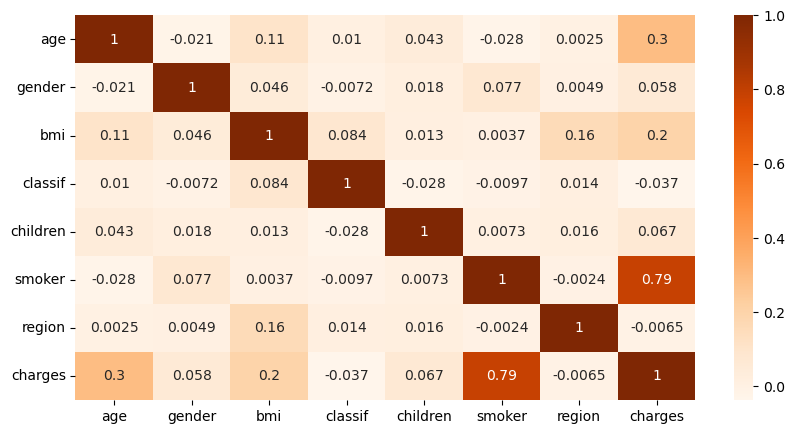

In [30]:
correlation_matrix=ins_data.corr()
plt.figure(figsize=(10,5))
sns.heatmap(correlation_matrix,annot=True,cmap="Oranges")
plt.show()

In [31]:
ins_data.drop(["region"],axis=1,inplace=True)

In [32]:
A=ins_data.drop(["charges"],axis=1)

### Scaling Data

In [33]:
scaled_data=pd.DataFrame(StandardScaler().fit_transform(A),columns=A.columns)

In [34]:
scaled_data["charges"]=ins_data["charges"]
scaled_data

,age,gender,bmi,classif,children,smoker,charges
0,-1.443070,-1.009771,-0.453160,1.282425,-0.909234,1.969660,16884.92400
1,-1.514521,0.990324,0.509422,-0.691407,-0.079442,-0.507702,1725.55230
2,-0.800013,0.990324,0.383155,-0.691407,1.580143,-0.507702,4449.46200
3,-0.014055,0.990324,-1.305052,-1.349351,-0.909234,-0.507702,21984.47061
4,-0.514210,0.990324,-0.292456,1.282425,-0.909234,-0.507702,3866.85520
...,...,...,...,...,...,...,...
1332,0.771903,0.990324,0.050269,-0.691407,1.580143,-0.507702,10600.54830
1333,-1.514521,-1.009771,0.206053,-0.691407,-0.909234,-0.507702,2205.98080
1334,-1.514521,-1.009771,1.014490,-0.033463,-0.909234,-0.507702,1629.83350
1335,-1.300169,-1.009771,-0.797524,1.282425,-0.909234,-0.507702,2007.94500


In [35]:
X=scaled_data.drop(["charges"],axis=1)
y=scaled_data["charges"]

## Metrics collection

In [36]:
def adjusted_r2_score(model,x,y):
    r2_scores=model.score(x,y)
    n=x.count()
    x=len(x_test.columns)-1
    adjusted_r2_score=1-((1-r2_scores)*(n-1)/(n-x-1))
    return adjusted_r2_score[0]

In [37]:
r2_train=[]
r2_test=[]
rmse=[]
mse=[]
mae=[]
mape=[]
def metrics():
    r2_train.append(R2_TRAIN)
    r2_test.append(R2_TEST)
    rmse.append(RMSE)
    mse.append(MSE)
    mae.append(MAE)
    mape.append(MAPE)
    

In [38]:
def metrics_print(model):
    print("Model adjusted r2 score on training data :",adjusted_r2_score(model,x_train,y_train))
    print("Model adjusted r2 score on test data :",adjusted_r2_score(model,x_test,y_test))
    
    average_adjusted_r2_score_train.append(adjusted_r2_score(model,x_train,y_train))
    average_adjusted_r2_score_test.append(adjusted_r2_score(model,x_test,y_test))
    print()
    
    RMSE1=mean_squared_error(y_test,y_pred,squared=False)
    print("RMSE:",RMSE1)
    avg_rmse.append(RMSE1)
    
    MSE1=mean_squared_error(y_test,y_pred)
    print("MSE:",MSE1)
    avg_mse.append(MSE1)
    
    MAE1=mean_absolute_error(y_test,y_pred)
    print("MAE:",MAE1)
    avg_mae.append(MAE1)
    
    MAPE1=mean_absolute_percentage_error(y_test,y_pred)
    print("MAPE:",MAPE1)
    avg_mape.append(MAPE1)
    print("--"*50)


In [39]:
def metrics_print1(model):
    R2_TRAIN=adjusted_r2_score(model,x_train,y_train)
    R2_TEST=adjusted_r2_score(model,x_test,y_test)
    print("Model adjusted r2 score on training data :",R2_TRAIN)
    print("Model adjusted r2 score on test data:",R2_TEST)
    print()


    RMSE=mean_squared_error(y_test,y_pred,squared=False)
    print("RMSE:",RMSE)

    MSE=mean_squared_error(y_test,y_pred)
    print("MSE:",MSE)

    MAE=mean_absolute_error(y_test,y_pred)
    print("MAE:",MAE)

    MAPE=mean_absolute_percentage_error(y_test,y_pred)
    print("MAPE:",MAPE)

    r2_train.append(R2_TRAIN)
    r2_test.append(R2_TEST)
    rmse.append(RMSE)
    mse.append(MSE)
    mae.append(MAE)
    mape.append(MAPE)

### Splitting Data

In [40]:
kf=KFold(n_splits=5, shuffle=True, random_state=42)

In [41]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# ---------------------------------------------Model Creation----------------------------------------------

## Multi-Linear Regression

In [42]:
average_adjusted_r2_score_train=[]
average_adjusted_r2_score_test=[]
avg_rmse=[]
avg_mse=[]
avg_mae=[]
avg_mape=[]
for train_data,test_data in kf.split(scaled_data):
    train,test=scaled_data.iloc[train_data],scaled_data.iloc[test_data]
    x_train=train.drop(["charges"],axis=1)
    y_train=train["charges"]
    
    x_test=test.drop(["charges"],axis=1)
    y_test=test["charges"]
    
    lin_model=LinearRegression().fit(x_train,y_train)
    y_pred=lin_model.predict(x_test)
    
    print("Intercept:",lin_model.intercept_)
    print("slope:",lin_model.coef_)
    print()
    
    metrics_print(lin_model)
    
RMSE=np.mean(avg_rmse)  
MSE=np.mean(avg_mse) 
MAE=np.mean(avg_mae) 
MAPE=np.mean(avg_mape)
R2_TRAIN=np.mean(average_adjusted_r2_score_train)
R2_TEST=np.mean(average_adjusted_r2_score_test)

print("Average adjusted r2 score of train data on different K-Fold",R2_TRAIN)
print("Average adjusted r2 score of test data on different K-Fold",R2_TEST)
metrics()


Intercept: 13212.971432509075
slope: [3511.23029388  -16.89497384 1889.73063362 -673.02179313  682.93680435
 9462.97384855]

Model adjusted r2 score on training data : 0.7422309611597342
Model adjusted r2 score on test data : 0.7734448170705385

RMSE: 6141.7426486092245
MSE: 37721002.76174545
MAE: 4158.91216399448
MAPE: 0.43069673104999595
----------------------------------------------------------------------------------------------------
Intercept: 13079.950070768698
slope: [3665.03180346 -108.61460587 2142.11485476 -371.77968023  591.70222917
 9415.4065034 ]

Model adjusted r2 score on training data : 0.7497362100538304
Model adjusted r2 score on test data : 0.7468759597839073

RMSE: 6150.395214906551
MSE: 37827361.2995454
MAE: 4052.2620185960445
MAPE: 0.42327858689973663
----------------------------------------------------------------------------------------------------
Intercept: 13273.639608849011
slope: [3535.94870166  -11.61651686 2025.07259628 -642.53673251  560.16701574
 9632.

## Decision Tree Regression

In [43]:
param_grid={'min_samples_split':np.arange(10,51,10),
           'min_samples_leaf':np.arange(10,101,20),
           'max_depth':np.arange(3,15)}

In [44]:
dt=DecisionTreeRegressor()

In [45]:
grid_cv=GridSearchCV(dt,param_grid,scoring="r2",cv=kf)

In [401]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([10, 30, 50, 70, 90]),
                         'min_samples_split': array([10, 20, 30, 40, 50])},
             scoring='r2')

In [402]:
grid_cv.best_estimator_

DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=30)

In [46]:
dt_model=DecisionTreeRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=30).fit(x_train,y_train)
y_pred=dt_model.predict(x_test)

In [47]:
metrics_print1(dt_model)

Model adjusted r2 score on training data : 0.8643280003520606
Model adjusted r2 score on test data: 0.8723954601195165

RMSE: 3950.223374498671
MSE: 15604264.708435668
MAE: 2547.1911374637525
MAPE: 0.3493685536931986


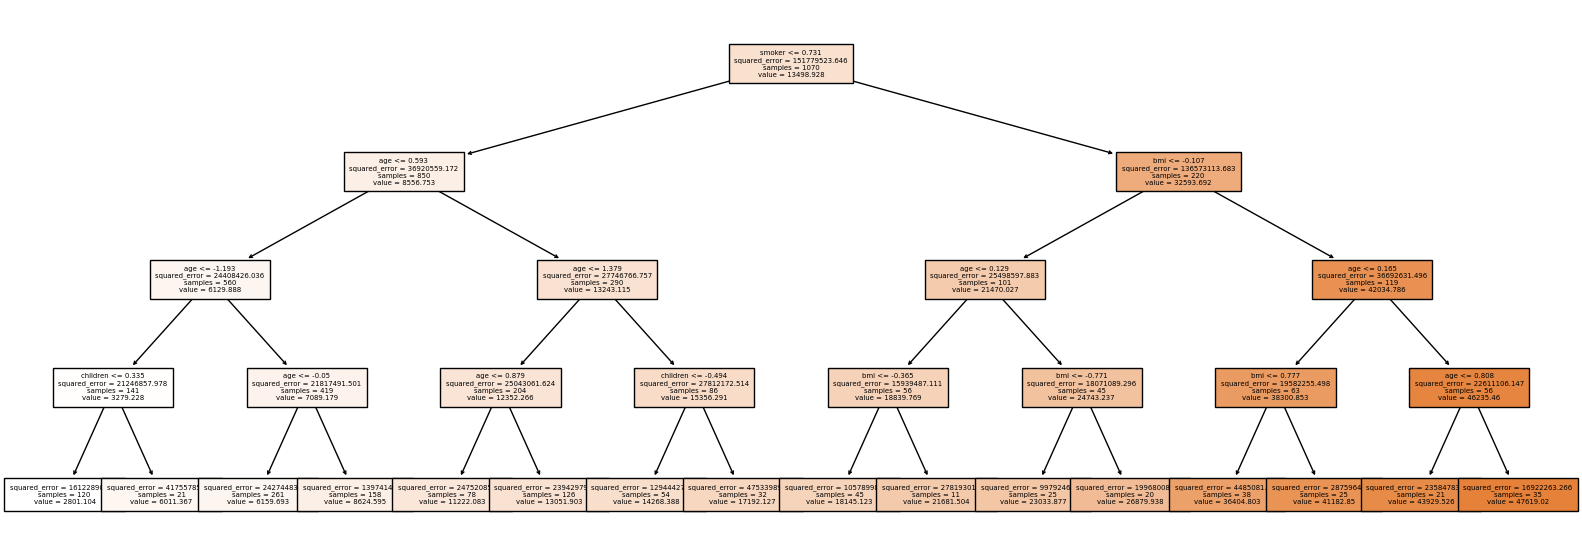

In [405]:
plt.figure(figsize=(20,7))
tree.plot_tree(dt_model,feature_names=X.columns,filled=True,fontsize=5)
plt.show()

## Random Forest Regression

In [48]:
param_grid={'n_estimators':np.arange(20,201,20),
           'min_samples_split':np.arange(10,51,10),
           'min_samples_leaf':np.arange(10,101,20),
           'max_depth':np.arange(3,15)}

In [49]:
rf=RandomForestRegressor()

In [57]:
grid_cv=GridSearchCV(rf,param_grid,scoring="r2",cv=kf)

In [409]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(),
             param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([10, 30, 50, 70, 90]),
                         'min_samples_split': array([10, 20, 30, 40, 50]),
                         'n_estimators': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180, 200])},
             scoring='r2')

In [410]:
grid_cv.best_estimator_

RandomForestRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=20,
                      n_estimators=200)

In [50]:
rf_model=RandomForestRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=20,n_estimators=200,random_state=42).fit(x_train,y_train)
y_pred=rf_model.predict(x_test)

In [51]:
metrics_print1(rf_model)

Model adjusted r2 score on training data : 0.8697780380670121
Model adjusted r2 score on test data: 0.877471128421625

RMSE: 3870.863069164605
MSE: 14983580.900222424
MAE: 2362.1835364097624
MAPE: 0.3368891298830509


## Adaboost Regression

In [52]:
param_grid={"n_estimators": np.arange(10,101,10),
           "learning_rate":np.arange(0.05,1,0.05)}

In [53]:
ada=AdaBoostRegressor()

In [62]:
grid_cv=GridSearchCV(ada,param_grid,scoring="r2",cv=kf)

In [416]:
grid_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100])},
             scoring='r2')

In [417]:
grid_cv.best_estimator_

AdaBoostRegressor(learning_rate=0.05, n_estimators=10)

In [54]:
ada_model=AdaBoostRegressor(learning_rate=0.05,n_estimators=10, random_state=42).fit(x_train,y_train)
y_pred=ada_model.predict(x_test)

In [55]:
metrics_print1(ada_model)

Model adjusted r2 score on training data : 0.8562179173418878
Model adjusted r2 score on test data: 0.8564406277549689

RMSE: 4189.90684056054
MSE: 17555319.33257601
MAE: 2827.74941584433
MAPE: 0.42843587968825214


## K-Nearest Neighbour

In [420]:
r2_scores=[]
for k in range(2,25):
    knn_score=cross_val_score(KNeighborsRegressor(k),x_train,y_train,scoring="r2",cv=kf)
    r2_scores.append(np.mean(knn_score))

In [421]:
for k in range(2,25):
    print("number of neighbors:",k,":",r2_scores[k-2])

number of neighbors: 2 : 0.7737926665791512
number of neighbors: 3 : 0.8059158086655112
number of neighbors: 4 : 0.8146770415449032
number of neighbors: 5 : 0.8205185500286385
number of neighbors: 6 : 0.8231921748720957
number of neighbors: 7 : 0.8266070785451131
number of neighbors: 8 : 0.8303023761847124
number of neighbors: 9 : 0.8307978996689105
number of neighbors: 10 : 0.8304514301443827
number of neighbors: 11 : 0.8298567262381706
number of neighbors: 12 : 0.8295075768794025
number of neighbors: 13 : 0.8296198372800682
number of neighbors: 14 : 0.828664942337787
number of neighbors: 15 : 0.8293147248747001
number of neighbors: 16 : 0.830343614763102
number of neighbors: 17 : 0.8292007128298874
number of neighbors: 18 : 0.8268786830912394
number of neighbors: 19 : 0.8261442265135674
number of neighbors: 20 : 0.8251203006469743
number of neighbors: 21 : 0.8246818224366171
number of neighbors: 22 : 0.8244029811478878
number of neighbors: 23 : 0.823739315416951
number of neighbors: 

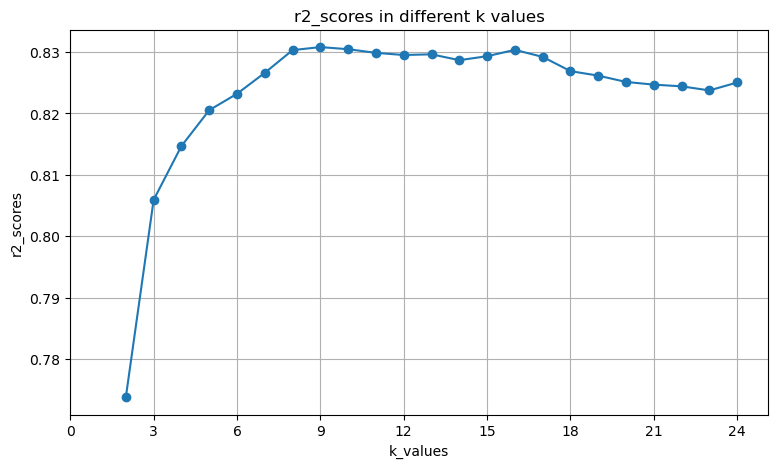

In [422]:
plt.figure(figsize=(9,5))
plt.plot(range(2,25),r2_scores,marker="o")
plt.ylabel("r2_scores")
plt.xlabel("k_values")
plt.title("r2_scores in different k values")
plt.xticks(range(0,25,3))
plt.grid()
plt.show()

In [56]:
k=9
knn_model=KNeighborsRegressor(k).fit(x_train,y_train)
y_pred=knn_model.predict(x_test)

In [57]:
metrics_print1(knn_model)

Model adjusted r2 score on training data : 0.8691318923951212
Model adjusted r2 score on test data: 0.8506826289129713

RMSE: 4273.106913997074
MSE: 18259442.698449597
MAE: 2691.24038165876
MAPE: 0.3805444344157079


## Stacked Regression

In [58]:
level1=[]
level1.append(("lr",LinearRegression()))
level1.append(("dt",DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, min_samples_split=10)))
level1.append(("rf",RandomForestRegressor(max_depth=4, min_samples_leaf=10, min_samples_split=20,random_state=42)))
level1.append(("ada",AdaBoostRegressor(learning_rate=0.05,n_estimators=10)))
level1.append(("knn",KNeighborsRegressor(9)))
level1.append(("svr",SVR()))

level2=LinearRegression()


In [59]:
stack_model=StackingRegressor(estimators=level1,final_estimator=level2,cv=kf).fit(X,y)
y_pred=stack_model.predict(x_test)

In [60]:
metrics_print1(stack_model)

Model adjusted r2 score on training data : 0.8700122726819599
Model adjusted r2 score on test data: 0.8930477346691873

RMSE: 3616.4593295493264
MSE: 13078778.082284365
MAE: 2112.8176067998584
MAPE: 0.2885514650115444


## ---------------------------------------------------- Best Model Selection---------------------------------------------------

In [61]:
model_list=["Linear Regression","Decision Tree Regression","Random Forest Regression","Ada-boost Regression","KNN Regression","Stacked Regression"]
metric_list=["Models","r2 Score(Train)","r2 Score(Test)","RMSE","MSE","MAE","MAPE"]

In [62]:
final_results=pd.DataFrame()
for i in range(0,len(model_list)):
    x=[[model_list[i],r2_train[i],r2_test[i],rmse[i],mse[i],mae[i],mape[i]]]
    new=pd.DataFrame(x)
    final_results=pd.concat([final_results,new],axis=0)
final_results.columns=metric_list
final_results=final_results.reset_index(drop=True)  
final_results

,Models,r2 Score(Train),r2 Score(Test),RMSE,MSE,MAE,MAPE
0,Linear Regression,0.751314,0.736294,6096.042991,3.721909e+07,4208.658091,0.432161
1,Decision Tree Regression,0.864328,0.872395,3950.223374,1.560426e+07,2547.191137,0.349369
2,Random Forest Regression,0.869778,0.877471,3870.863069,1.498358e+07,2362.183536,0.336889
3,Ada-boost Regression,0.856218,0.856441,4189.906841,1.755532e+07,2827.749416,0.428436
4,KNN Regression,0.869132,0.850683,4273.106914,1.825944e+07,2691.240382,0.380544
5,Stacked Regression,0.870012,0.893048,3616.459330,1.307878e+07,2112.817607,0.288551


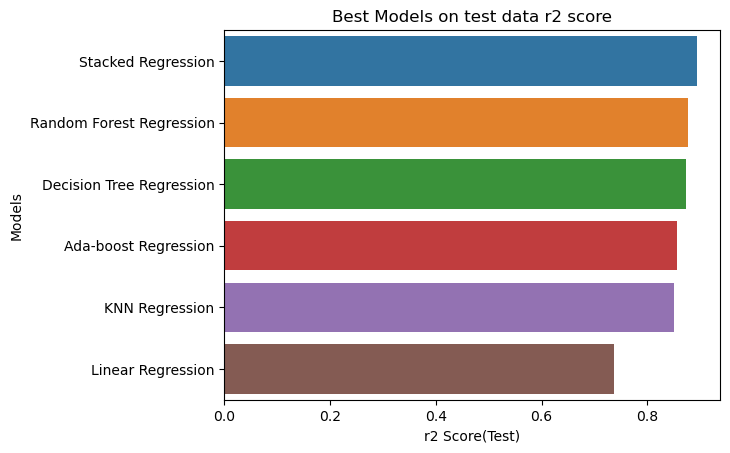

In [63]:
results=final_results.sort_values("r2 Score(Test)",ascending=False)
sns.barplot(x="r2 Score(Test)",y="Models",data=results)
plt.title("Best Models on test data r2 score")
plt.show()

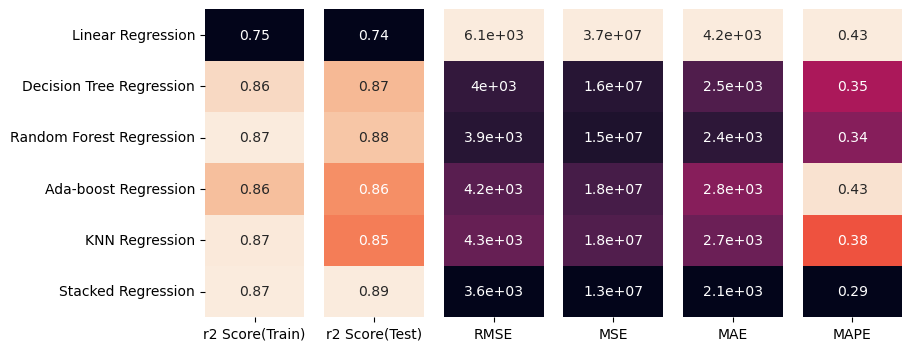

In [64]:
fig,ax=plt.subplots(1,6,figsize=(9,4))

sns.heatmap(final_results[["r2 Score(Train)"]],annot=True,yticklabels=model_list,ax=ax[0],cbar=False)
sns.heatmap(final_results[["r2 Score(Test)"]],annot=True,ax=ax[1],yticklabels=False,cbar=False)
sns.heatmap(final_results[["RMSE"]],annot=True,ax=ax[2],yticklabels=False,cbar=False)
sns.heatmap(final_results[["MSE"]],annot=True,ax=ax[3],yticklabels=False,cbar=False)
sns.heatmap(final_results[["MAE"]],annot=True,ax=ax[4],yticklabels=False,cbar=False)
sns.heatmap(final_results[["MAPE"]],annot=True,ax=ax[5],yticklabels=False,cbar=False)

plt.show()

In [65]:
lin_score=average_adjusted_r2_score_test
dt_score=cross_val_score(dt_model,X,y,scoring="r2",cv=kf)
rf_score=cross_val_score(rf_model,X,y,scoring="r2",cv=kf)
ada_score=cross_val_score(ada_model,X,y,scoring="r2",cv=kf)
knn_score=cross_val_score(knn_model,X,y,scoring="r2",cv=kf)
stack_score=cross_val_score(stack_model,X,y,scoring="r2",cv=kf)

all_scores=[lin_score,dt_score,rf_score,ada_score,knn_score,stack_score]

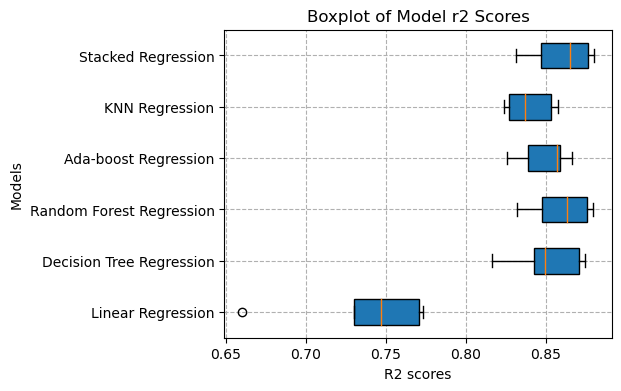

In [66]:
plt.figure(figsize=(5,4))
plt.boxplot(all_scores,labels=model_list,vert=False,patch_artist=True)
plt.title("Boxplot of Model r2 Scores")
plt.xlabel("R2 scores")
plt.ylabel("Models")
plt.grid(axis='y', linestyle='--')
plt.grid(axis='x', linestyle='--')
plt.show()

### Best fitted model will be Stacked Regression Model